# Module 4 Project - Introduction    

**Business Case**  The business care here is quite simple.  A real estate investor would like to know the top five zip codes to invest based on the provided data.  This is left intentionally vague, giving us a few potential questions to answer.
- What criteria should I use to evaluate the investments?
- What quantitative targets should be used to evaluate the models?
- What are the 5 best zip codes for investment?

In [1]:
#Importing all of the necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from scipy import stats
from math import log
from statistics import mean
import itertools
import statsmodels.api as sm
import random
import datetime
plt.style.use('ggplot')
%matplotlib inline

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Step 1: Load the Data

In [2]:
#Loading all of the datasets
df = pd.read_csv('zillow_data.csv').dropna()
name_abbr = pd.read_csv('name_abbr.csv', names=['state', 'abbr'])
census_1996 = pd.read_csv('census_1996.csv').drop(0).reset_index(drop=True)
census_2018 = pd.read_csv('census_2018.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Preprocessing Data/Filtering for Chosen Zipcodes

In [3]:
census_2018.drop(list(range(51,64)), inplace=True)
census_2018['State'] = census_1996['state']
census_2018.head()

,State,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,"4,779,736","4,780,125","4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"710,231","710,249","713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,392,017","6,392,288","6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,915,918","2,916,031","2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,253,956","37,254,519","37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"


In [4]:
#Creating a 'diff' column showing the percent change between oldest and most recent prices
df_diff = df.copy()
df_diff['diff'] = df_diff.iloc[:,-1] - df_diff.iloc[:,7]
df_diff['diff'] = df_diff['diff'] / df_diff.iloc[:,-2] * 100
df_diff.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,diff
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,67.572288
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,26.755749
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,36.223098
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,61.889824
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,36.378601


In [5]:
#Filtering so that the top 10% of 'diff' zip codes remain
top_ten = df_diff['diff'].quantile(q=.97)
top_zip = df_diff[df_diff['diff'] >= top_ten].reset_index(drop=True)
top_zip.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,diff
0,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500,79.913465
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,83.181063
2,66126,20002,Washington,DC,Washington,District of Columbia,30,94300.0,94000.0,93700.0,...,668000,672200,673100,674600,678200,680900,683000,687500,691300,86.359034
3,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900,82.683410
4,66133,20009,Washington,DC,Washington,District of Columbia,34,178800.0,179200.0,179600.0,...,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200,83.416806


In [6]:
#Getting a normalized value count to see how many times the states appear
states = top_zip['State'].value_counts(normalize=True).sort_index()
state_avg = top_zip.groupby(by='State').mean()['diff']

In [7]:
#Cleaning up data, specifically creating a new dataset, renaming columns
#And converting some of the data to integer format
pop_data = pd.concat([name_abbr['abbr'], census_1996['7/1/96'], census_2018['2018']], axis=1)
pop_data.rename(columns={'abbr': 'state', '7/1/96': '1996'}, inplace=True)
pop_data['2018'] = [int(i.replace(',','')) for i in pop_data['2018']]
pop_data['pop_diff'] = pop_data['2018'] - pop_data['1996']
pop_data.set_index(pop_data['state'], drop=True, inplace=True)
pop_data.head()

,state,1996,2018,pop_diff
state,,,,
AL,AL,4290403,4887681,597278
AK,AK,604918,735139,130221
AZ,AZ,4432308,7158024,2725716
AR,AR,2504858,3009733,504875
CA,CA,31780829,39461588,7680759


In [8]:
#Creating 2 new columns, the first one showing percent change in population
#The second showing the share for each state adjusted for population
top_pop = pd.concat([states, pop_data, state_avg], join='inner', axis=1).drop('state', axis=1)
top_pop['pop_percent'] = top_pop['pop_diff'] / top_pop['1996']
top_pop.rename(columns={'State': 'share'}, inplace=True)
top_pop['adj_share'] = top_pop['share'] / top_pop['2018'] * 1E12
top_pop.head()

,share,1996,2018,pop_diff,diff,pop_percent,adj_share
AZ,0.005168,4432308,7158024,2725716,81.653649,0.614965,721.981186
CA,0.483204,31780829,39461588,7680759,81.117770,0.241679,12244.923706
CO,0.023256,3812716,5691287,1878571,82.615540,0.492712,4086.213532
DC,0.020672,538273,701547,163274,83.069302,0.303329,29466.072302
DE,0.007752,727090,965479,238389,83.241341,0.327867,8029.110923


In [9]:
def get_datetimes(top_zip):
    return pd.to_datetime(top_zip.columns.values[7:-1], format='%Y-%m')
datetimes = get_datetimes(top_zip)
print(datetimes[-1])

2018-04-01 00:00:00


In [10]:
#Dropping some unnecessary columns from the dataframe
pre_data = top_zip.drop(['RegionID','SizeRank', 'diff'], axis=1)
pre_data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,11226,New York,NY,New York,Kings,162000.0,162300.0,162600.0,163000.0,163400.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
2,20002,Washington,DC,Washington,District of Columbia,94300.0,94000.0,93700.0,93600.0,93400.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,20009,Washington,DC,Washington,District of Columbia,178800.0,179200.0,179600.0,180000.0,180300.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200


In [11]:
#Creating a dataframe only containing the timeseries data
ts_values = top_zip.iloc[:, 7:-1]
ts_values.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,766000.0,771100.0,776500.0,781900.0,787300.0,793000.0,799100.0,805800.0,814400.0,824300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,167900.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
2,94300.0,94000.0,93700.0,93600.0,93400.0,93400.0,93400.0,93600.0,94000.0,94500.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
3,340600.0,341700.0,343000.0,344400.0,346100.0,348000.0,350300.0,353000.0,356400.0,360400.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,178800.0,179200.0,179600.0,180000.0,180300.0,180700.0,181200.0,181800.0,182600.0,183700.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200


In [12]:
#Creating a list of month abbreviations by pulling them from datetime
month_list = [datetime.date(2020, i, 1).strftime('%b') for i in range(1,13)]
print(month_list)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [13]:
#Finding the average price for each month during the entire range
monthly_avg = []
n = 1
while n < 13:
    temp_list = []
    for x in range(len(ts_values.columns)):
        month = int(ts_values.columns[x][-2] + ts_values.columns[x][-1])
        if month == n:
            temp_list.append(ts_values.iloc[:,x].mean())
    monthly_avg.append(mean(temp_list))
    n+=1

# Step 3: EDA and Visualization

In [14]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [15]:
#Setting a random seed for reproducibility and creating a list of random integers
random.seed(a=22)
rand_list = random.sample(range(0, len(top_zip)), 10)

In [16]:
#List of average values at each point in the time series for the top zips
#As well as one for the original data
ts_avg = ts_values.mean()
df_avg = df.iloc[:,7:].mean()

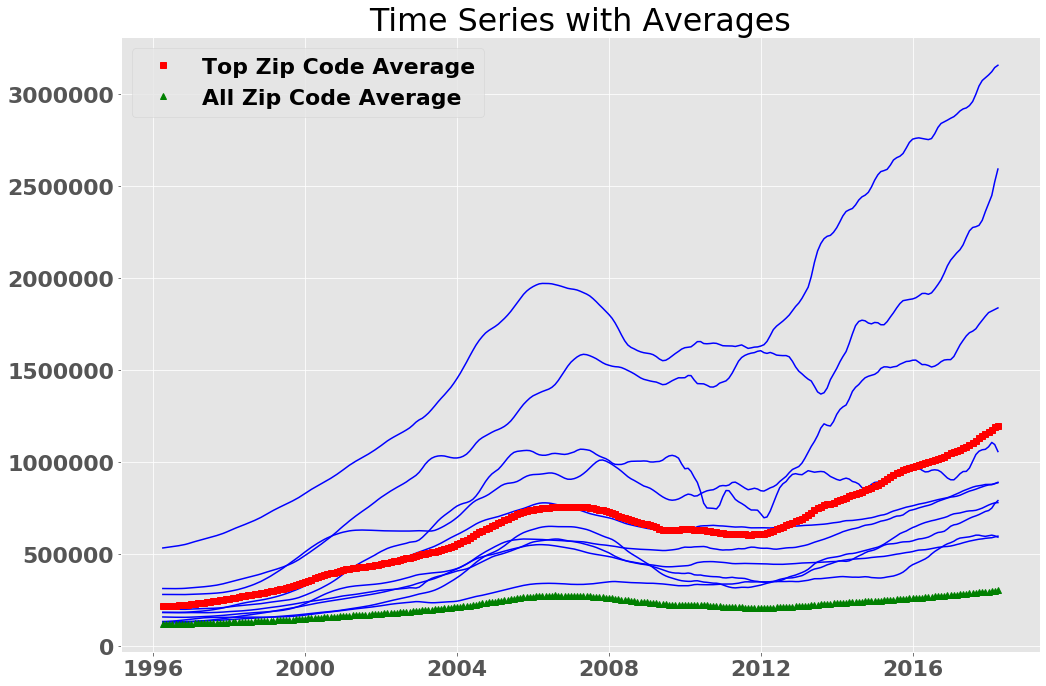

In [98]:
#Plotting a random selection of zip codes, along with average for the top zips
#And the average for the entire original dataset
plt.figure(figsize=(15,10))
for x in rand_list:
    plt.plot(datetimes, ts_values.iloc[x,:], 'b')

plt.plot(datetimes, ts_avg, 'rs', label='Top Zip Code Average')
plt.plot(datetimes, df_avg, 'g^', label='All Zip Code Average')
plt.title('Time Series with Averages')
plt.legend()
plt.tight_layout()
plt.savefig('time_series.png', dpi = 300)
plt.show()

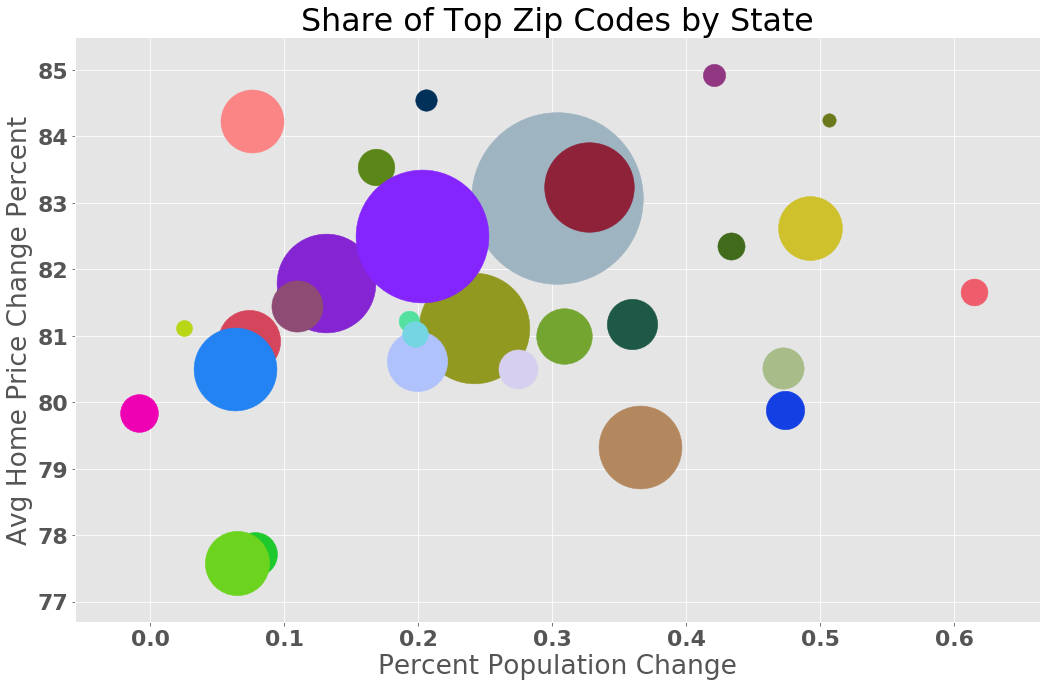

In [99]:
#Scatter plot with each state, size of dot based on their share of the top_zip group
#Randomly colored
plt.figure(figsize=(15,10))
for x, y, z in zip(top_pop['pop_percent'], state_avg, top_pop['adj_share']):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, s=z, c=[rgb])
plt.xlabel('Percent Population Change')
plt.ylabel('Avg Home Price Change Percent')
plt.title('Share of Top Zip Codes by State')
plt.tight_layout()
plt.savefig('share_by_state.png', dpi = 300)
plt.show()

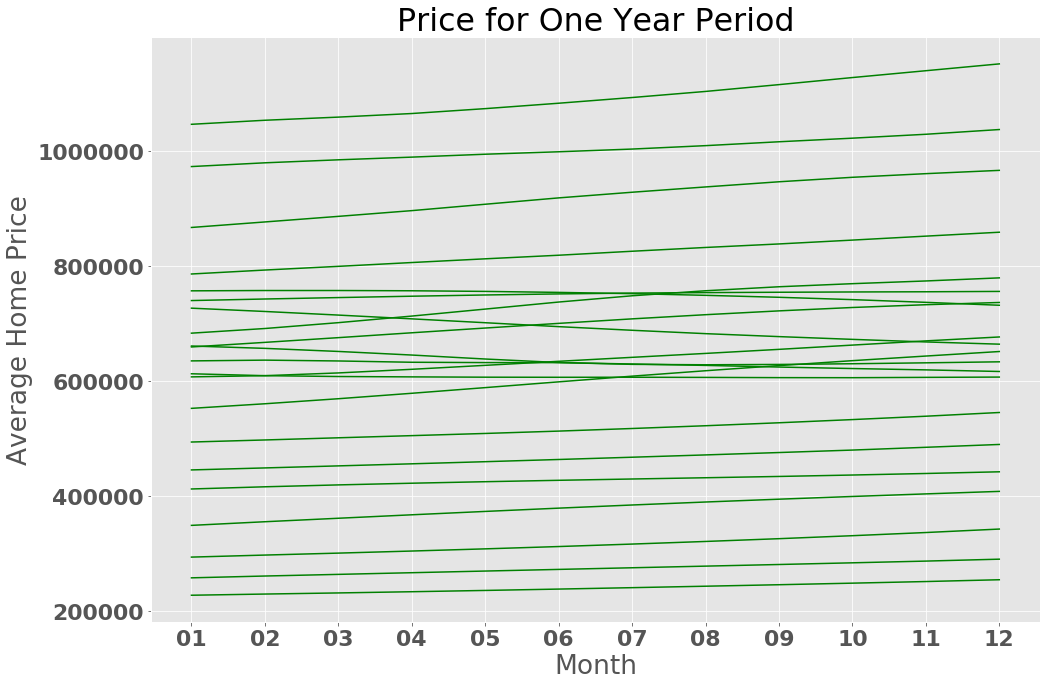

In [100]:
#Graph to check for seasonal changes, one line for each year
plt.figure(figsize=(15,10))
for x in range(1997,2018):
    yearly_list = []
    avg_list = []
    for i in ts_avg.index:       
        if x == int(i[0:4]):
            yearly_list.append(i[-2:])
            avg_list.append(ts_avg[i])
    plt.plot(yearly_list, avg_list, c='g')
plt.xlabel('Month')
plt.ylabel('Average Home Price')
plt.title('Price for One Year Period')
plt.tight_layout()
plt.savefig('one_year_red.png', dpi = 300)
plt.show()

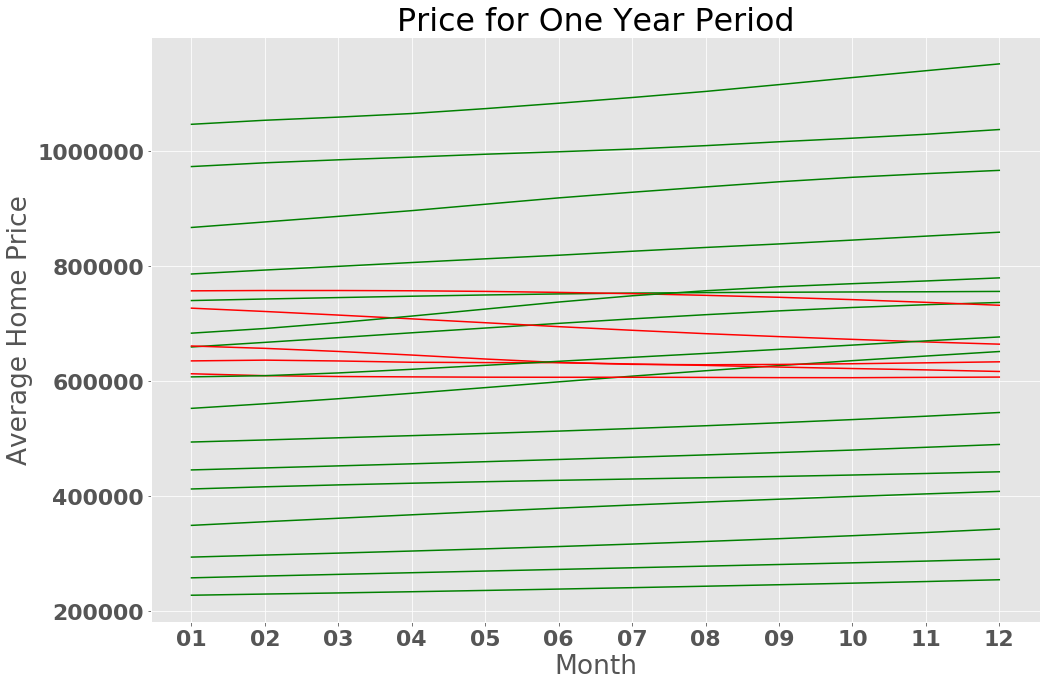

In [107]:
#Same as previous graph, but with the years from the financial crisis in red
plt.figure(figsize=(15,10))
for x in range(1997,2018):
    c = 'g'
    yearly_list = []
    avg_list = []
    for i in ts_avg.index:       
        if x == int(i[0:4]):
            yearly_list.append(i[-2:])
            avg_list.append(ts_avg[i])
        if x >= 2007 and x <= 2011:
            c = 'r'
    plt.plot(yearly_list, avg_list, c=c)
plt.xlabel('Month')
plt.ylabel('Average Home Price')
plt.title('Price for One Year Period')
plt.tight_layout()
plt.savefig('one_year_green.png', dpi = 300)
plt.show()

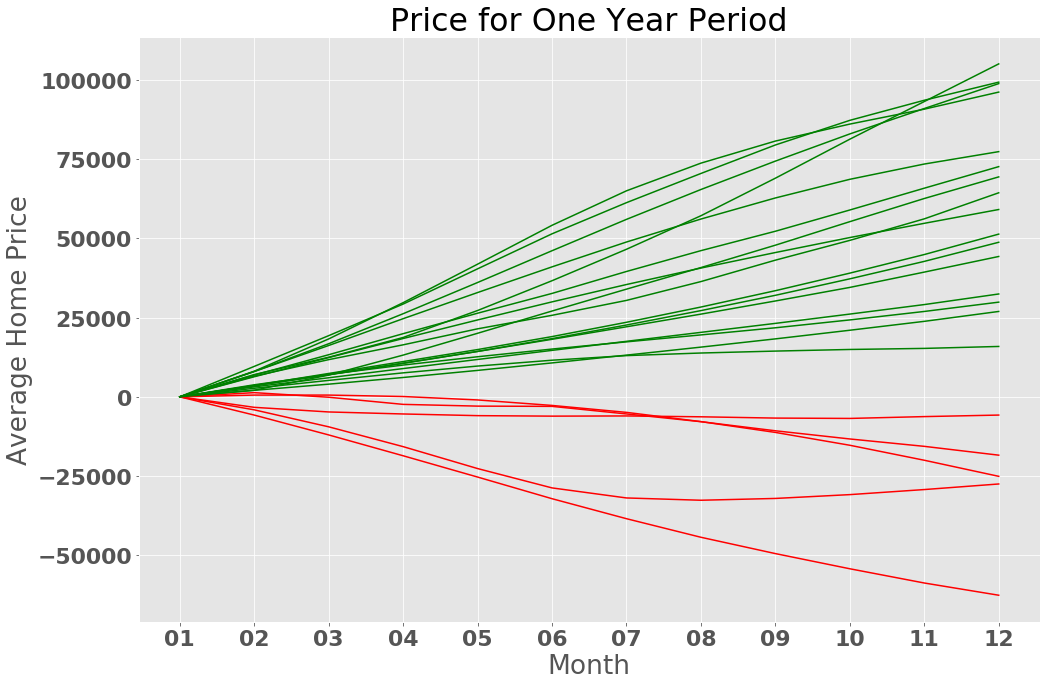

In [106]:
#Same as previous graph, but with start point of each graph zeroed out
#This way the y-axis isn't so stretched and seasonal movement is easier to see
plt.figure(figsize=(15,10))
for x in range(1997,2018):
    c = 'g'
    yearly_list = []
    avg_list = []
    for i in ts_avg.index:       
        if x == int(i[0:4]):
            yearly_list.append(i[-2:])
            avg_list.append(ts_avg[i])
        if x >= 2007 and x <= 2011:
            c = 'r'
    zero_list = [y-avg_list[0] for y in avg_list]
    plt.plot(yearly_list, zero_list, c=c)
plt.xlabel('Month')
plt.ylabel('Average Home Price')
plt.title('Price for One Year Period')
plt.tight_layout()
plt.savefig('one_year_zero.png', dpi = 300)
plt.show()


# Step 4: Reshape from Wide to Long Format

In [21]:
#Melting the dataframe to put it into long format
melted_df = pd.melt(pre_data, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], \
                    value_vars=pre_data.columns[5:], var_name='time')
melted_df['time'] = pd.to_datetime(melted_df['time'], format='%Y-%m')
melted_df.head()

,RegionName,City,State,Metro,CountyName,time,value
0,94109,San Francisco,CA,San Francisco,San Francisco,1996-04-01,766000.0
1,11226,New York,NY,New York,Kings,1996-04-01,162000.0
2,20002,Washington,DC,Washington,District of Columbia,1996-04-01,94300.0
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-04-01,340600.0
4,20009,Washington,DC,Washington,District of Columbia,1996-04-01,178800.0


In [22]:
#Creating a time series for the average of all zip codes
melted_ts = melted_df.set_index('time')
values_test = melted_ts['value'].resample('MS').mean()
values_test.head()

time
1996-04-01    218110.594315
1996-05-01    218735.142119
1996-06-01    219409.302326
1996-07-01    220140.051680
1996-08-01    220949.870801
Freq: MS, Name: value, dtype: float64

In [23]:
#Setting the Region Name as the index so that the next step works
melted_zips = melted_df.set_index('RegionName')
melted_zips.head()

,City,State,Metro,CountyName,time,value
RegionName,,,,,,
94109,San Francisco,CA,San Francisco,San Francisco,1996-04-01,766000.0
11226,New York,NY,New York,Kings,1996-04-01,162000.0
20002,Washington,DC,Washington,District of Columbia,1996-04-01,94300.0
90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-04-01,340600.0
20009,Washington,DC,Washington,District of Columbia,1996-04-01,178800.0


In [49]:
#Creating a dictionary for each zip code containing that zip's time series
zip_melt_dict = {}
for x in melted_zips.index.unique():
    zip_melt_dict.update({str(x): melted_zips.loc[x, ['time', 'value']].set_index('time')})
  

# Step 5: ARIMA Modeling

In [96]:
# Defining the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
# Running a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(values_test,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) : AIC Calculated =5443.622644711519
ARIMA (0, 0, 1) : AIC Calculated =5349.357732730021


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) : AIC Calculated =5321.341380201171


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 3) : AIC Calculated =5308.434731008831


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 4) : AIC Calculated =5437.14646331121


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 5) : AIC Calculated =5263.807445900731
ARIMA (0, 1, 0) : AIC Calculated =3987.7607204282076
ARIMA (0, 1, 1) : AIC Calculated =3845.8217977762424


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) : AIC Calculated =3762.3833009542077


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) : AIC Calculated =3733.59615794793


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 4) : AIC Calculated =3702.1950903539046


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 5) : AIC Calculated =3702.3400781014943
ARIMA (0, 2, 0) : AIC Calculated =3485.7807417718104
ARIMA (0, 2, 1) : AIC Calculated =3344.384716532093


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) : AIC Calculated =3344.6599302695686


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) : AIC Calculated =3293.75515058173


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 4) : AIC Calculated =3276.227789852838


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 5) : AIC Calculated =3332.995242322536
ARIMA (0, 3, 0) : AIC Calculated =3511.220933746991


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 3, 1) : AIC Calculated =3432.8990409948483


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 3, 2) : AIC Calculated =3321.3292101642346


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 3, 3) : AIC Calculated =3310.4762216100544


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 3, 4) : AIC Calculated =3323.5447346677956


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 3, 5) : AIC Calculated =3347.451822784318
ARIMA (0, 4, 0) : AIC Calculated =3589.710292093558


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 4, 1) : AIC Calculated =3433.428449902944


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 4, 2) : AIC Calculated =3444.014262389791
ARIMA (0, 4, 3) : AIC Calculated =3423.2691775082567


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 4, 4) : AIC Calculated =3371.26604402102


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 4, 5) : AIC Calculated =3385.992961823784
ARIMA (0, 5, 0) : AIC Calculated =3729.882654632184
ARIMA (0, 5, 1) : AIC Calculated =3594.6967326756267


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 5, 2) : AIC Calculated =3520.8482851376475
ARIMA (0, 5, 3) : AIC Calculated =3522.7793717674413


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 5, 4) : AIC Calculated =3484.746860618357


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 5, 5) : AIC Calculated =3508.450134032277


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) : AIC Calculated =4067.6794779441025
ARIMA (1, 0, 1) : AIC Calculated =4134.602991914234


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) : AIC Calculated =4114.371681728728


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 3) : AIC Calculated =4388.228129572535


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 4) : AIC Calculated =3888.833495381487


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 5) : AIC Calculated =4354.499966957271


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) : AIC Calculated =3483.7316153569254


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) : AIC Calculated =3361.0879195421494


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) : AIC Calculated =3345.1328464807384


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) : AIC Calculated =3317.151139682608


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 4) : AIC Calculated =3308.476632351259


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 5) : AIC Calculated =3371.111930474861


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) : AIC Calculated =3418.4853157409866


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) : AIC Calculated =3340.865396068337


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) : AIC Calculated =3329.368101992897


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) : AIC Calculated =3329.5655410103454


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 4) : AIC Calculated =3297.4372659343244


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 5) : AIC Calculated =3333.236367407164
ARIMA (1, 3, 0) : AIC Calculated =3516.528473037766


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 3, 1) : AIC Calculated =3446.5065372330937


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 3, 2) : AIC Calculated =3338.8123159033757


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 3, 3) : AIC Calculated =3286.1911970899537


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 3, 4) : AIC Calculated =3351.668586946413


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 3, 5) : AIC Calculated =3347.295895313172
ARIMA (1, 4, 0) : AIC Calculated =3594.3001532133194


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 4, 1) : AIC Calculated =3509.9380468418008


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 4, 2) : AIC Calculated =3438.505983652047


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 4, 3) : AIC Calculated =3423.775108857927


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 4, 4) : AIC Calculated =3355.5787452099535


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 4, 5) : AIC Calculated =3388.779692189427
ARIMA (1, 5, 0) : AIC Calculated =3704.260481442968
ARIMA (1, 5, 1) : AIC Calculated =3589.8451180539064


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 5, 2) : AIC Calculated =3516.4456611326505


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 5, 3) : AIC Calculated =3520.524267381288


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 5, 4) : AIC Calculated =3485.7670898167153


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 5, 5) : AIC Calculated =3493.7541155680174


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) : AIC Calculated =3645.648738974675


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) : AIC Calculated =3623.136366638195


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) : AIC Calculated =3550.9355126505425


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 3) : AIC Calculated =3548.346653232895


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 4) : AIC Calculated =3535.9397900458252


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 5) : AIC Calculated =3524.7627931015404
ARIMA (2, 1, 0) : AIC Calculated =3463.4351288417142


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) : AIC Calculated =3410.4385786454213


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) : AIC Calculated =3390.8621313885415


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) : AIC Calculated =3375.2809688819702


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 4) : AIC Calculated =3339.562219451908


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 5) : AIC Calculated =3340.526947189399


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) : AIC Calculated =3414.433685497006


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) : AIC Calculated =3335.987814426555


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) : AIC Calculated =3317.7829989058564


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) : AIC Calculated =3402.853044076187


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 4) : AIC Calculated =3336.7304844196788


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 5) : AIC Calculated =3326.7751004215793


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 0) : AIC Calculated =3366.660264640329


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 1) : AIC Calculated =3394.045349372317


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 2) : AIC Calculated =3376.6255193426905


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 3) : AIC Calculated =3303.4692678787096


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 4) : AIC Calculated =3334.729825370722


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 3, 5) : AIC Calculated =3316.9720744732404


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 0) : AIC Calculated =3473.8039035141683


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 1) : AIC Calculated =3379.6516110686875


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 2) : AIC Calculated =3378.2406103604526


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 3) : AIC Calculated =3374.3650617092944


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 4) : AIC Calculated =3335.735830078099


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 4, 5) : AIC Calculated =3349.8736504015333
ARIMA (2, 5, 0) : AIC Calculated =3630.919789456758


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 5, 1) : AIC Calculated =3454.276319274356
ARIMA (2, 5, 2) : AIC Calculated =3464.2376273469517


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 5, 3) : AIC Calculated =3435.274544173943


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 5, 4) : AIC Calculated =3421.0436891537925


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 5, 5) : AIC Calculated =3419.770732060945


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 0) : AIC Calculated =3616.190447249738


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 1) : AIC Calculated =3606.139737570429


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 2) : AIC Calculated =3644.438119176335


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 3) : AIC Calculated =3533.6525461193387


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 4) : AIC Calculated =3635.3398331798617


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 0, 5) : AIC Calculated =3725.8465282624884


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) : AIC Calculated =3445.251459276392


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) : AIC Calculated =3415.7807535450693


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) : AIC Calculated =3387.354423130358


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) : AIC Calculated =3369.778438272908


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 4) : AIC Calculated =3337.701880581015


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 5) : AIC Calculated =3336.164874861967


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) : AIC Calculated =3374.075977891822


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) : AIC Calculated =3390.7060293053696


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) : AIC Calculated =3364.462177694512


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) : AIC Calculated =3345.478631506758


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 4) : AIC Calculated =3334.250196428539


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 5) : AIC Calculated =3323.9014324667455


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 0) : AIC Calculated =3408.5365875353395


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 1) : AIC Calculated =3401.583810297203


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 2) : AIC Calculated =3376.7651249731425


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 3) : AIC Calculated =3333.4910382742246


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 4) : AIC Calculated =3334.381146735811


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 3, 5) : AIC Calculated =3318.5047235565744


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 0) : AIC Calculated =3457.6230773338775


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 1) : AIC Calculated =3394.2964245852236


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 2) : AIC Calculated =3407.385671114622


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 3) : AIC Calculated =3374.9492867353824


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 4) : AIC Calculated =3337.7836649812652


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 4, 5) : AIC Calculated =3357.238350681855


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 0) : AIC Calculated =3557.7746780095963


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 1) : AIC Calculated =3521.9119582395606


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 2) : AIC Calculated =3430.7629090001874


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 3) : AIC Calculated =3435.0739368234463


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 4) : AIC Calculated =3408.184066254093


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 5, 5) : AIC Calculated =3403.705257032385


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 0) : AIC Calculated =3465.9687178768936


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 1) : AIC Calculated =3599.6882891328


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 2) : AIC Calculated =3626.5176519597267


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 3) : AIC Calculated =3645.0291005410536


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 4) : AIC Calculated =3629.411855419593


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 0, 5) : AIC Calculated =4109.760725601023


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 0) : AIC Calculated =3424.2802868247722


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 1) : AIC Calculated =3394.3556638843875


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 2) : AIC Calculated =3383.7155212306598


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 3) : AIC Calculated =3353.9544782306343


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 4) : AIC Calculated =3332.226148129208


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 1, 5) : AIC Calculated =3338.307765579383


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 0) : AIC Calculated =3395.853828483681


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 1) : AIC Calculated =3378.7096548510817


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 2) : AIC Calculated =3378.1450918864994


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 3) : AIC Calculated =3345.9149752828885


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 4) : AIC Calculated =3333.9749908565036


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 2, 5) : AIC Calculated =3324.034752965083


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 0) : AIC Calculated =3420.228474137436


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 1) : AIC Calculated =3400.3439312274154


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 2) : AIC Calculated =3382.58560932028


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 3) : AIC Calculated =3341.3962330946883


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 4) : AIC Calculated =3331.4074251542347


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 3, 5) : AIC Calculated =3295.169099576169


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 0) : AIC Calculated =3470.7096001361947


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 1) : AIC Calculated =3436.8899157872693


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 2) : AIC Calculated =3397.680057895032


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 3) : AIC Calculated =3361.639796979025


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 4) : AIC Calculated =3339.0383018605744


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 4, 5) : AIC Calculated =3345.3649291443176


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 0) : AIC Calculated =3538.144274917091


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 1) : AIC Calculated =3514.918614864725


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 2) : AIC Calculated =3460.073804876428


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 3) : AIC Calculated =3428.7800744664373


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 4) : AIC Calculated =3407.737212520011


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (4, 5, 5) : AIC Calculated =3403.1400695832745


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 0) : AIC Calculated =3576.7998160259003


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 1) : AIC Calculated =3566.011376391035


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 2) : AIC Calculated =3595.0505588387587


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 3) : AIC Calculated =3720.954866828499


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 4) : AIC Calculated =3690.7878841250936


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 0, 5) : AIC Calculated =4216.117670954343


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 0) : AIC Calculated =3426.5351015369306


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 1) : AIC Calculated =3396.7491422984267


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 2) : AIC Calculated =3381.4896761749833


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 3) : AIC Calculated =3354.3752003578884


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 4) : AIC Calculated =3326.5314179767433


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 1, 5) : AIC Calculated =3334.1132212147777


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 0) : AIC Calculated =3404.1695382088237


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 1) : AIC Calculated =3378.0763576944437


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 2) : AIC Calculated =3381.71623675469


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 3) : AIC Calculated =3348.28674921987


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 4) : AIC Calculated =3334.4327018848567


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 2, 5) : AIC Calculated =3322.6204346127415


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 0) : AIC Calculated =3404.4066892470037


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 1) : AIC Calculated =3397.8883833099662


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 2) : AIC Calculated =3390.250829072572


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 3) : AIC Calculated =3343.0202028781523


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 4) : AIC Calculated =3334.77239892351


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 3, 5) : AIC Calculated =3313.686313494077


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 0) : AIC Calculated =3422.612285818943


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 1) : AIC Calculated =3414.2954347331124


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 2) : AIC Calculated =3397.883152310107


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 3) : AIC Calculated =3353.572325107005


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 4) : AIC Calculated =3334.9842920311003


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 4, 5) : AIC Calculated =3341.9838697029413


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 0) : AIC Calculated =3484.538580038022


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 1) : AIC Calculated =3451.050877566847


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 2) : AIC Calculated =3436.439898576608


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 3) : AIC Calculated =3401.451220686885


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 4) : AIC Calculated =3343.7024771476126


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (5, 5, 5) : AIC Calculated =3366.961970182697


In [27]:
# Finding the parameters with smallest AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (0, 2, 4)
aic      3276.23
Name: 16, dtype: object

In [28]:
# Plugging the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(values_test, 
                                        order=(0, 2, 4), 
                                        seasonal_order=(1, 2, 3, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fitting the model and printing results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0564      0.183      5.763      0.000       0.697       1.416
ma.L2          0.0252      0.157      0.161      0.872      -0.282       0.332
ma.L3         -0.3240      0.141     -2.305      0.021      -0.599      -0.048
ma.L4          0.2206      0.081      2.729      0.006       0.062       0.379
ar.S.L12      -0.3888      0.078     -5.000      0.000      -0.541      -0.236
ma.S.L12      -0.8864      0.128     -6.907      0.000      -1.138      -0.635
ma.S.L24       0.1238      0.094      1.313      0.189      -0.061       0.308
ma.S.L36      -0.1460      0.094     -1.555      0.120      -0.330       0.038
sigma2      7.249e+05    1.4e+05      5.190      0.000    4.51e+05    9.99e+05


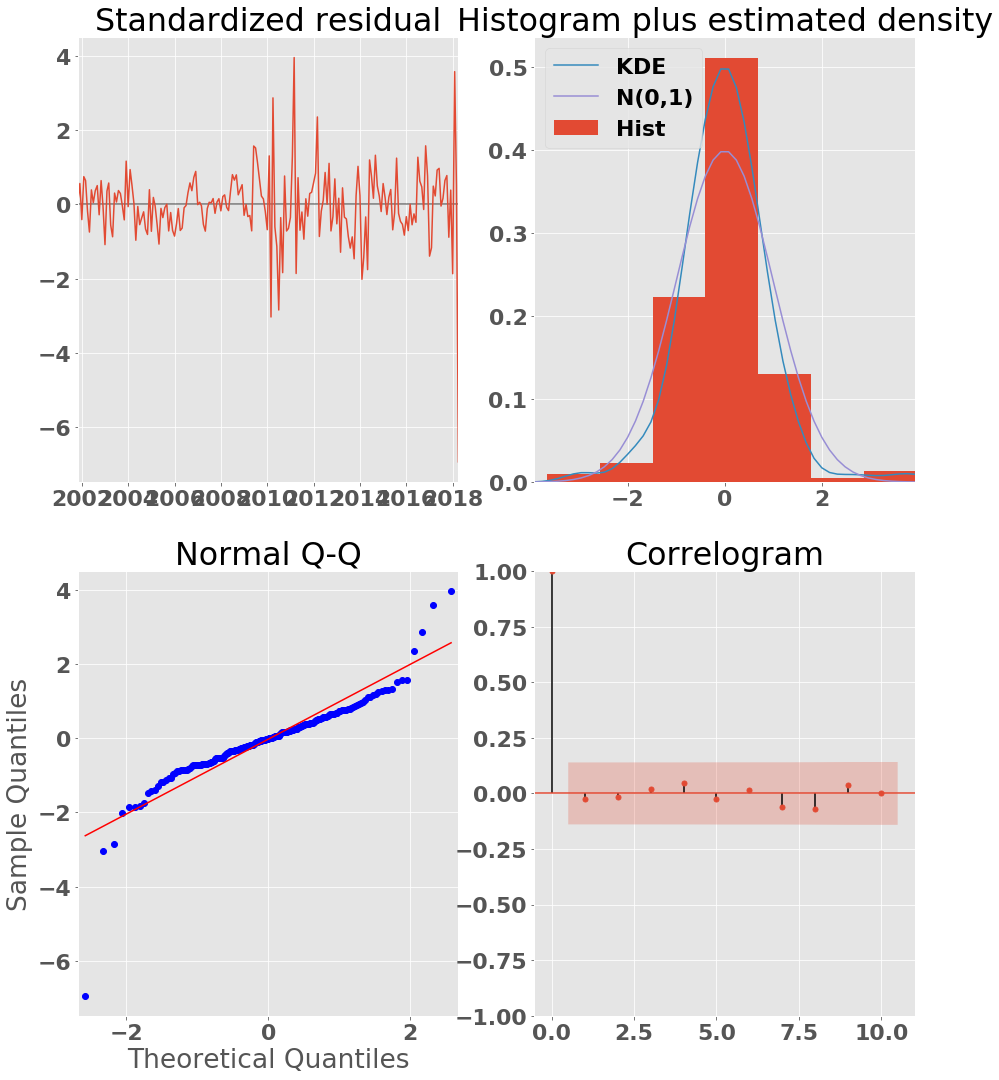

In [29]:
#Printing the diagnostics
output.plot_diagnostics(figsize=(15, 18))
plt.show()

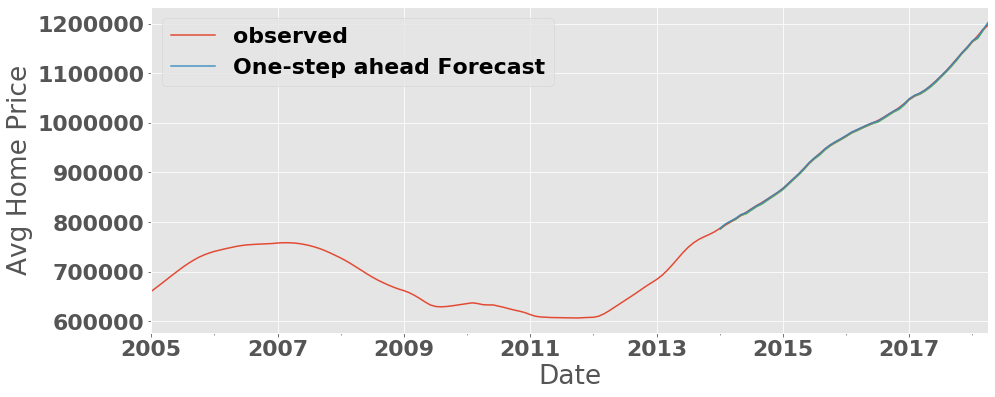

In [30]:
#Plotting the one step ahead forecast alongside the actual values
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = values_test['2005':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Price')
plt.legend()

plt.show()

In [31]:
# Get the real and predicted values
value_forecasted = pred.predicted_mean
value_truth = values_test['2014-01-01':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1408117.43


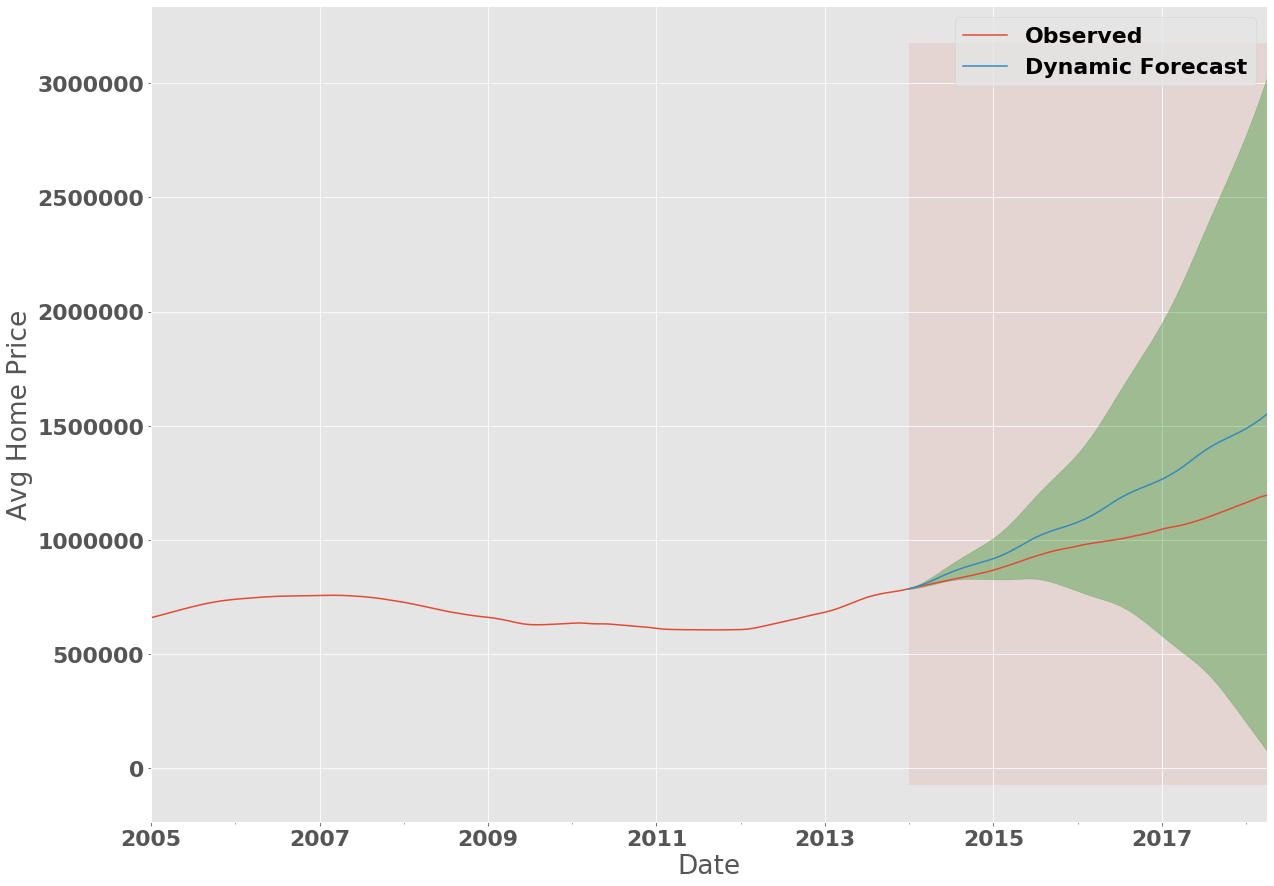

In [32]:
#Plotting the dynamic forecast
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

ax = ax = values_test['2005':].plot(label='Observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Price')

plt.legend()
plt.show()

In [124]:
#Calculating the mean squared error for the dynamic forecast
value_forecasted = pred_dynamic.predicted_mean
value_truth = values_test['2014-01-01':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 168930743.14


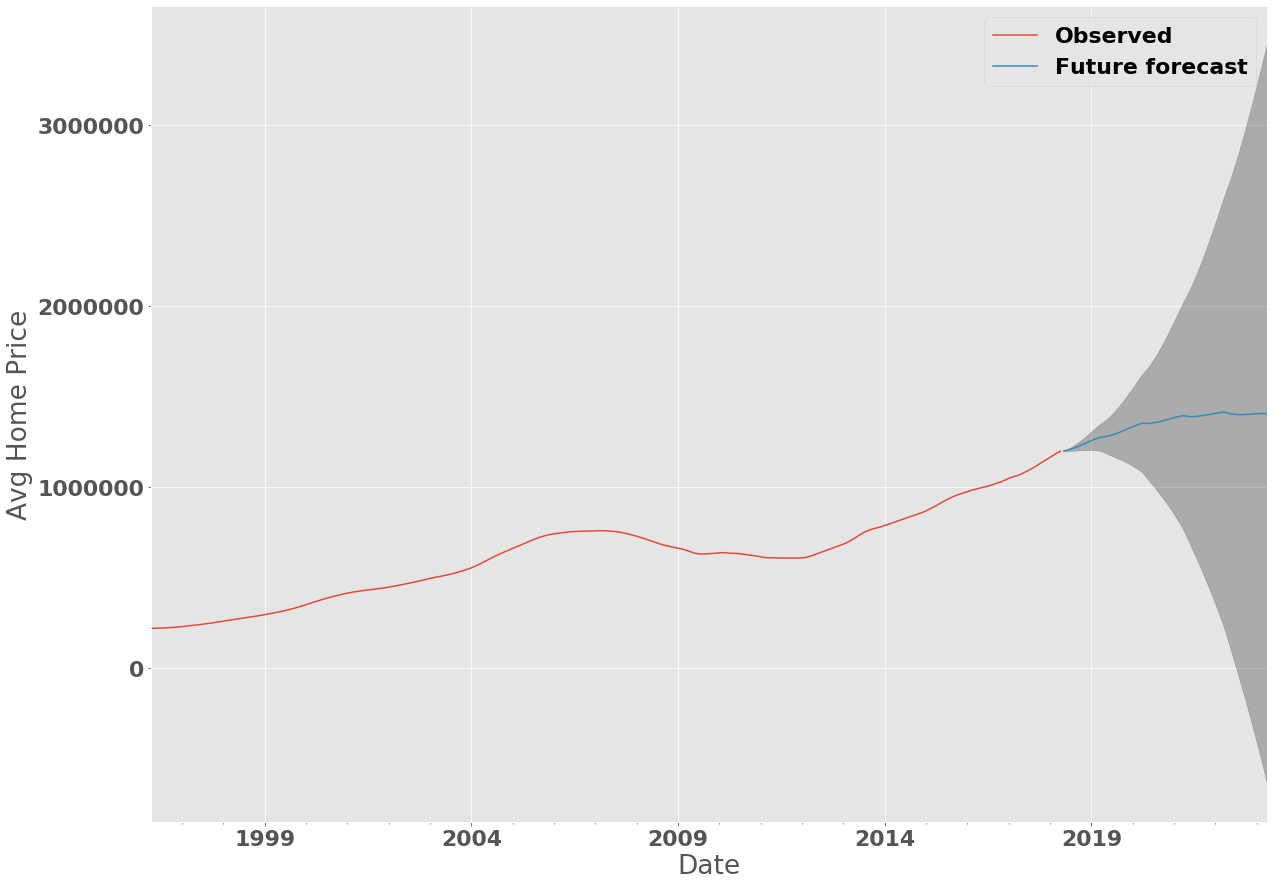

In [33]:
#Plotting the future forecast
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = values_test.plot(label='Observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Future forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Price')

plt.legend()
plt.show()

In [50]:
#Cycle through the zip codes applying the model to each one.
zip_ans = []
for x in zip_melt_dict.keys():
    try:
        single_df = zip_melt_dict[x]
        ARIMA_MODEL = sm.tsa.statespace.SARIMAX(single_df, 
                                                order=(0, 2, 4), 
                                                seasonal_order=(1, 2, 3, 12), 
                                                enforce_stationarity=False)

        output = ARIMA_MODEL.fit()  
        prediction = output.get_forecast(steps=60)
        pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
        pred_conf = pred.conf_int()
        value_forecasted = pred.predicted_mean
        value_truth = single_df['2014-01-01':]   
        mse = ((value_forecasted - value_truth) ** 2).mean()

        zip_ans.append([mse, prediction.predicted_mean[-1], output.aic])
        zip_ans_df = pd.DataFrame(zip_ans, columns=['MSE', 'pred', 'aic'])
    except:
            continue

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbri

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/

In [51]:
zip_key_df = pd.DataFrame(zip_melt_dict.keys(), columns=['zip'])
zip_ans_df.sort_values('pred', ascending=False).head()

,MSE,pred,aic
360,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,2.155940e+07,4360.434451
270,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.615540e+07,4158.603551
105,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.591359e+07,4070.722533
265,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.482274e+07,4308.330358
292,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.359133e+07,4175.109386


In [73]:
#Creating a list of the most recent price from each ZIP
last_price_list = []
for x in zip_melt_dict.keys():
    temp_dict = zip_melt_dict[x]
    last_price_list.append(temp_dict['value'][-1])

In [87]:
# Running a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(values_test,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

<class 'pandas.core.frame.DataFrame'>


In [83]:
#adding 'price' 'diff' and 'ROI' columns to help evaluate investments
merged_zips = zip_ans_df.merge(zip_key_df, left_index=True, right_index=True)
merged_zips['price'] = last_price_list
merged_zips['diff'] = merged_zips['pred'] - merged_zips['price']
merged_zips['ROI'] = merged_zips['diff'] / merged_zips['price'] *100
sorted_zips = merged_zips.sort_values('ROI', ascending=False)
sorted_zips.head()

,MSE,pred,aic,zip,price,diff,ROI
360,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,2.155940e+07,4360.434451,11959,1602300.0,1.995710e+07,1245.528401
151,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,9.599433e+06,4058.437791,95134,1525200.0,8.074233e+06,529.388458
105,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.591359e+07,4070.722533,94025,2561200.0,1.335239e+07,521.333372
191,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,6.833433e+06,3803.535669,94063,1213800.0,5.619633e+06,462.978495
139,2014-01-01 00:00:00 NaN 2014-02-01 00:00:00 ...,1.146751e+07,3974.196927,95129,2110700.0,9.356811e+06,443.303714


In [86]:
#Selecting the top 15 zip codes for further testing
selected_zips = list(sorted_zips['zip'].head(15))
print(selected_zips)

['11959', '95134', '94025', '94063', '95129', '90802', '95128', '94041', '95050', '95126', '95051', '90057', '95030', '95133', '98119']


In [200]:
# Running a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for x in selected_zips:
    for comb in pdq:
            try:
                single_df = zip_melt_dict[x]
                mod = sm.tsa.statespace.SARIMAX(single_df,
                                                order=comb,
                                                seasonal_order=(1,2,3,12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([x, comb, output.aic])
                print('{} ARIMA {} : AIC Calculated ={}'.format(x, comb, output.aic))
            except:
                continue
zip_ans_list = ans

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (0, 0, 0) : AIC Calculated =6121.171209580272


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (0, 0, 1) : AIC Calculated =5966.68791671834


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (0, 1, 0) : AIC Calculated =4636.465165183843


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (0, 1, 1) : AIC Calculated =4486.546368427989


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (1, 0, 0) : AIC Calculated =5239.681099430152


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (1, 0, 1) : AIC Calculated =5031.757753357044


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (1, 1, 0) : AIC Calculated =4467.233485416769


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11959 ARIMA (1, 1, 1) : AIC Calculated =4395.266006177566


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (0, 0, 0) : AIC Calculated =5974.6327347318


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (0, 0, 1) : AIC Calculated =5929.758465823695


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (0, 1, 0) : AIC Calculated =4523.524097129058


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (0, 1, 1) : AIC Calculated =4363.438533737924


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (1, 0, 0) : AIC Calculated =5047.046152917743


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (1, 0, 1) : AIC Calculated =4843.493875684001


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (1, 1, 0) : AIC Calculated =4248.3875216854885


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95134 ARIMA (1, 1, 1) : AIC Calculated =4140.565399460032


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (0, 0, 0) : AIC Calculated =6112.97085167075


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (0, 0, 1) : AIC Calculated =6033.141748754689


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (0, 1, 0) : AIC Calculated =4562.592987065938


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (0, 1, 1) : AIC Calculated =4441.753166833938


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (1, 0, 0) : AIC Calculated =5160.087651425787


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (1, 0, 1) : AIC Calculated =4976.549223829966


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (1, 1, 0) : AIC Calculated =4206.3505600563385


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94025 ARIMA (1, 1, 1) : AIC Calculated =4132.014802525466


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (0, 0, 0) : AIC Calculated =5807.230368556799


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (0, 0, 1) : AIC Calculated =5670.944550588421


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (0, 1, 0) : AIC Calculated =4326.167471274799


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (0, 1, 1) : AIC Calculated =4170.125547993665


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (1, 0, 0) : AIC Calculated =4723.122450604861


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (1, 0, 1) : AIC Calculated =4545.0869479846515


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (1, 1, 0) : AIC Calculated =3990.142559719369


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94063 ARIMA (1, 1, 1) : AIC Calculated =3916.0479330322833


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (0, 0, 0) : AIC Calculated =6029.7349793565445


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95129 ARIMA (0, 0, 1) : AIC Calculated =5899.589665446574


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (0, 1, 0) : AIC Calculated =4507.298469457851


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (0, 1, 1) : AIC Calculated =4428.7659970075665


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (1, 0, 0) : AIC Calculated =5110.765332260178


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (1, 0, 1) : AIC Calculated =4938.794816269918


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (1, 1, 0) : AIC Calculated =4149.944936102081


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95129 ARIMA (1, 1, 1) : AIC Calculated =4058.734083249976


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (0, 0, 0) : AIC Calculated =5464.821428991314


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (0, 0, 1) : AIC Calculated =5314.690574753123


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (0, 1, 0) : AIC Calculated =4152.006649783765


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90802 ARIMA (0, 1, 1) : AIC Calculated =3892.26240466796


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90802 ARIMA (1, 0, 0) : AIC Calculated =4167.923056443103


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (1, 0, 1) : AIC Calculated =3975.040866267157


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (1, 1, 0) : AIC Calculated =3907.7227620391554


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90802 ARIMA (1, 1, 1) : AIC Calculated =3831.6202374998475


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (0, 0, 0) : AIC Calculated =5742.926932258002


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (0, 0, 1) : AIC Calculated =5664.09652150962


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (0, 1, 0) : AIC Calculated =4264.315286021532


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (0, 1, 1) : AIC Calculated =4126.014770093148


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (1, 0, 0) : AIC Calculated =4684.550560913044


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (1, 0, 1) : AIC Calculated =4514.507505917181


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (1, 1, 0) : AIC Calculated =3905.0074253995413


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95128 ARIMA (1, 1, 1) : AIC Calculated =3796.8107106784464


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94041 ARIMA (0, 0, 0) : AIC Calculated =6947.880347172804


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94041 ARIMA (0, 0, 1) : AIC Calculated =5990.982205507558


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94041 ARIMA (0, 1, 0) : AIC Calculated =4502.175067237966


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94041 ARIMA (0, 1, 1) : AIC Calculated =4367.58043478933


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94041 ARIMA (1, 0, 0) : AIC Calculated =6034.861227673204


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94041 ARIMA (1, 0, 1) : AIC Calculated =5735.988064873947


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94041 ARIMA (1, 1, 0) : AIC Calculated =4381.201316398996


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


94041 ARIMA (1, 1, 1) : AIC Calculated =4298.851110643624


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (0, 0, 0) : AIC Calculated =5749.486974654481


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (0, 0, 1) : AIC Calculated =5696.857365008027


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (0, 1, 0) : AIC Calculated =4302.113444016989


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (0, 1, 1) : AIC Calculated =4190.152937619434


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (1, 0, 0) : AIC Calculated =4740.509872480048


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95050 ARIMA (1, 0, 1) : AIC Calculated =4565.323107520901


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (1, 1, 0) : AIC Calculated =3921.5625513945006


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95050 ARIMA (1, 1, 1) : AIC Calculated =3858.6470208777073


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (0, 0, 0) : AIC Calculated =5786.48193190423


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (0, 0, 1) : AIC Calculated =5738.278527301472


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (0, 1, 0) : AIC Calculated =4319.458265233539


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (0, 1, 1) : AIC Calculated =4211.775694610764


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (1, 0, 0) : AIC Calculated =4811.175375156865


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (1, 0, 1) : AIC Calculated =4642.540587371115


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (1, 1, 0) : AIC Calculated =3985.9010634027645


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95126 ARIMA (1, 1, 1) : AIC Calculated =3896.9469113912473


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (0, 0, 0) : AIC Calculated =5749.915074888033


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (0, 0, 1) : AIC Calculated =5721.281485562702


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (0, 1, 0) : AIC Calculated =4313.681272991511


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95051 ARIMA (0, 1, 1) : AIC Calculated =4196.331138847749


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (1, 0, 0) : AIC Calculated =4822.868153672274


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95051 ARIMA (1, 0, 1) : AIC Calculated =4617.201609597962


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (1, 1, 0) : AIC Calculated =3999.2115160254843


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95051 ARIMA (1, 1, 1) : AIC Calculated =3902.6345960188396


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (0, 0, 0) : AIC Calculated =5539.385392895883


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (0, 0, 1) : AIC Calculated =5427.794830776304


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (0, 1, 0) : AIC Calculated =4256.562398709257


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (0, 1, 1) : AIC Calculated =4038.998316352033


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90057 ARIMA (1, 0, 0) : AIC Calculated =4275.5518194643155


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90057 ARIMA (1, 0, 1) : AIC Calculated =4087.218201302011


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (1, 1, 0) : AIC Calculated =4011.2098634383333


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


90057 ARIMA (1, 1, 1) : AIC Calculated =3914.930124451327


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (0, 0, 0) : AIC Calculated =6289.550709206826


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (0, 0, 1) : AIC Calculated =6273.609328757382


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (0, 1, 0) : AIC Calculated =4646.398116817478


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (0, 1, 1) : AIC Calculated =4543.858894864516


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (1, 0, 0) : AIC Calculated =5360.918531839738


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95030 ARIMA (1, 0, 1) : AIC Calculated =5174.432470735637


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (1, 1, 0) : AIC Calculated =4344.786625704112


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95030 ARIMA (1, 1, 1) : AIC Calculated =4250.937798602903


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (0, 0, 0) : AIC Calculated =5689.880361330748


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95133 ARIMA (0, 0, 1) : AIC Calculated =5613.825959158794


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (0, 1, 0) : AIC Calculated =4215.231961535374


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (0, 1, 1) : AIC Calculated =4079.5472008612724


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (1, 0, 0) : AIC Calculated =4624.014160932613


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (1, 0, 1) : AIC Calculated =4446.796665924938


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (1, 1, 0) : AIC Calculated =3911.1924225419734


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


95133 ARIMA (1, 1, 1) : AIC Calculated =3852.910056572967


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (0, 0, 0) : AIC Calculated =5559.2212248825845


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (0, 0, 1) : AIC Calculated =5414.23719947768


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (0, 1, 0) : AIC Calculated =4103.684938054002


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (0, 1, 1) : AIC Calculated =3979.7486672966397


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (1, 0, 0) : AIC Calculated =4471.025013285849


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (1, 0, 1) : AIC Calculated =4337.704718863184


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


98119 ARIMA (1, 1, 0) : AIC Calculated =3790.6435606876666


/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


98119 ARIMA (1, 1, 1) : AIC Calculated =3809.856638028143


In [202]:
resorted_zips = sorted_zips.reset_index(drop=True)
temp_list = []
zip_ans_list = ans
for x in range(15):
    temp_list = [resorted_zips['zip'][x], (0,2,4), resorted_zips['aic'][x]]
    zip_ans_list.append(temp_list)
    temp_list = []

In [204]:
zip_ans_df = pd.DataFrame(zip_ans_list, columns=['zip', 'comb', 'aic'])
zip_ans_df.set_index('zip', drop=True, inplace=True)
zip_ans_df.head()

,comb,aic
zip,,
11959,"(0, 0, 0)",6121.171210
11959,"(0, 0, 1)",5966.687917
11959,"(0, 1, 0)",4636.465165
11959,"(0, 1, 1)",4486.546368
11959,"(1, 0, 0)",5239.681099


In [205]:
#Creating a dict where each ZIP corresponds to it's parameters and AIC
loop_dict = {}
for x in zip_ans_df.index:
    loop_dict.update({x : zip_ans_df.loc[x, :].reset_index(drop=True)})

In [207]:
#Creating a dict that contains the optimal hyperparameters for each zip
aic_dict = {}
for x in loop_dict.keys():
    aic_list = loop_dict[x]
    aic_dict.update({x :aic_list.loc[aic_list['aic'].idxmin()]})
aic_db = pd.DataFrame.from_dict(aic_dict)
aic_db.head()

,11959,95134,94025,94063,95129,90802,95128,94041,95050,95126,95051,90057,95030,95133,98119
comb,"(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)","(0, 2, 4)"
aic,4360.43,4058.44,4070.72,3803.54,3974.2,3686.9,3735.55,3962.95,3776.82,3823.81,3820.75,3738.62,4175.11,3723.14,3724.59


In [88]:
#Cycle through the zip codes applying the model to each one.
zip_ans = []
for x in selected_zips:
    try:
        single_df = zip_melt_dict[x]
        ARIMA_MODEL = sm.tsa.statespace.SARIMAX(single_df, 
                                                order=(0, 2, 4), 
                                                seasonal_order=(1, 2, 3, 12), 
                                                enforce_stationarity=False)

        output = ARIMA_MODEL.fit()  
        prediction = output.get_forecast(steps=60)
        pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
        pred_conf = prediction.conf_int()
        value_forecasted = pred.predicted_mean
        value_truth = single_df['2014-01-01':]   
        mse = ((value_forecasted - value_truth) ** 2).mean()

        zip_ans.append([pred_conf, prediction.predicted_mean[-1], output.aic])
        select_ans_df = pd.DataFrame(zip_ans, columns=['conf', 'pred', 'aic'])
    except:
            continue

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/de

In [265]:
selected_zips_df = sorted_zips.iloc[0:15,:]
selected_zips_df.drop(['MSE', 'pred', 'aic'], inplace=True, axis=1)
selected_zips_df.reset_index(drop=True, inplace=True)
selected_zips_df.head()

,zip,price,diff,ROI
0,11959,1602300.0,1.995710e+07,1245.528401
1,95134,1525200.0,8.074233e+06,529.388458
2,94025,2561200.0,1.335239e+07,521.333372
3,94063,1213800.0,5.619633e+06,462.978495
4,95129,2110700.0,9.356811e+06,443.303714


In [264]:
select_ans_df['lower'] = 0
for x in range(len(select_ans_df)):
    select_ans_df.loc[x, 'lower'] = select_ans_df.loc[:,'conf'][x]['lower value'][-1]
select_ans_df.head()

,conf,pred,aic,lower
0,lower value upper value 2018-05...,2.155940e+07,4360.434451,-1.700486e+06
1,lower value upper value 2018-05...,9.599433e+06,4058.437791,-1.574806e+06
2,lower value upper value 2018-05...,1.591359e+07,4070.722533,-4.194091e+06
3,lower value upper value 2018-05...,6.833433e+06,3803.535669,1.453352e+05
4,lower value upper value 2018-05...,1.146751e+07,3974.196927,-8.726133e+05


In [266]:
final_df = selected_zips_df.merge(select_ans_df, left_index=True, right_index=True)
final_df['loss'] = final_df['pred'] - final_df['lower']
final_df['AROI'] = final_df['diff'] / final_df['loss']
final_df.sort_values('AROI', ascending=False).head()

,zip,price,diff,ROI,conf,pred,aic,lower,loss,AROI
11,90057,762500.0,2.655778e+06,348.298814,lower value upper value 2018-05...,3.418278e+06,3738.622920,1.198585e+06,2.219693e+06,1.196462
0,11959,1602300.0,1.995710e+07,1245.528401,lower value upper value 2018-05...,2.155940e+07,4360.434451,-1.700486e+06,2.325989e+07,0.858005
3,94063,1213800.0,5.619633e+06,462.978495,lower value upper value 2018-05...,6.833433e+06,3803.535669,1.453352e+05,6.688098e+06,0.840244
13,95133,1069800.0,3.503827e+06,327.521727,lower value upper value 2018-05...,4.573627e+06,3723.142731,3.890979e+04,4.534718e+06,0.772667
6,95128,1253000.0,4.794291e+06,382.625018,lower value upper value 2018-05...,6.047291e+06,3735.549311,-1.691141e+05,6.216406e+06,0.771232


# Step 6: Interpreting Results/Conclusions

In [ ]:
#Here, I will put most of the conclusion section from README as well as maybe a chart comparing the top_zips average
#results with the top five that I chose

Once this was all complete I was able to answer each of the three questions originally posed.  

- What criteria should I use to evaluate the investments?  
The answer here comes down to personal preference more so than any answer presented in the data.  I took a look at some reasonable investment standards and simply applied those.  For example, I chose to look at a time period of 5 years since that is a fairly standard investment time period, and it was short enough that a prediction would be more accurate and useful than ten or twenty years.  The evaluation metric I chose for this time period was risk-adjusted ROI.  This is because I wanted to provide investment advice that would give an optimal return while still controlling for downside risk.  

- What quantitative targets should be used to evaluate the models?   
In order to evaluate the models I again used fairly standard criteria.  While narrowing down optimal parameters I looked at the AIC score in order to make sure I was choosing a model that minimized overfitting and underfitting.  After optimal parameters had been selected, I also took MSE into consideration.  This was more indirect though, the error appeared in my investment analysis since it is considered when calculating the risk-adjusted return on investment.  
- What are the five best zip codes for investment?  
In the end, the five best zip codes that I would recommend are:
1. 90057
2. 11959
3. 94063
4. 95133
5. 95128